<a href="https://colab.research.google.com/github/click-b8/Gyro-Stabilization-Platform-/blob/main/MedMNIST_WAVE_Control_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medmnist


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn


In [ ]:
#Code Architecture: Wave Image ──► CNN Encoder ──┐
#                             ├──► Latent Fusion ──► Classifier ─► Sea State
#                    IMU Data ───► MLP Encoder ──┘

In [4]:
# dataset/
# ├── calm/
# │    ├── img_001.png
# │    ├── imu_001.csv
# ├── intermediate/
# └── rough/
# Each IMU / CSV Example: ax, ay, az, gx, gy, gz


In [5]:
!pip install torch torchvision numpy pandas pillow


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os


In [7]:
class SeaStateDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        self.label_map = {
            "calm": 0,
            "intermediate": 1,
            "rough": 2
        }

        for label in self.label_map:
            folder = os.path.join(root_dir, label)
            for f in os.listdir(folder):
                if f.endswith(".png"):
                    img_path = os.path.join(folder, f)
                    imu_path = img_path.replace(".png", ".csv")
                    self.samples.append((img_path, imu_path, self.label_map[label]))

    def extract_imu_features(self, imu_csv):
        data = pd.read_csv(imu_csv)
        features = []
        for col in data.columns:
            features.extend([
                data[col].mean(),
                data[col].std(),
                np.sqrt(np.mean(data[col]**2))
            ])
        return torch.tensor(features, dtype=torch.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, imu_path, label = self.samples[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        imu_features = self.extract_imu_features(imu_path)

        return image, imu_features, label


In [8]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


In [9]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128)
        )

    def forward(self, x):
        return self.net(x)


In [10]:
class IMUEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )

    def forward(self, x):
        return self.net(x)


In [11]:
class SeaStateModel(nn.Module):
    def __init__(self, imu_dim):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.imu_encoder = IMUEncoder(imu_dim)

        self.classifier = nn.Sequential(
            nn.Linear(128 + 64, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, image, imu):
        img_latent = self.image_encoder(image)
        imu_latent = self.imu_encoder(imu)
        fused = torch.cat([img_latent, imu_latent], dim=1)
        return self.classifier(fused)


In [14]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Root dataset directory
ROOT = "dataset"
CLASSES = {
    "calm": 0.2,
    "intermediate": 0.6,
    "rough": 1.2
}

NUM_SAMPLES_PER_CLASS = 50
IMG_SIZE = 64
IMU_SAMPLES = 200  # time steps

os.makedirs(ROOT, exist_ok=True)


In [15]:
def generate_wave_image(amplitude):
    x = np.linspace(0, 4*np.pi, IMG_SIZE)
    y = np.linspace(0, 4*np.pi, IMG_SIZE)
    X, Y = np.meshgrid(x, y)

    wave = amplitude * np.sin(X + Y)
    noise = np.random.normal(0, 0.2, (IMG_SIZE, IMG_SIZE))
    img = wave + noise

    # Normalize to 0–255
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)

    return Image.fromarray(img).convert("RGB")


In [16]:
def generate_imu_data(variance):
    t = np.linspace(0, 10, IMU_SAMPLES)

    data = {
        "ax": np.sin(t) + np.random.normal(0, variance, IMU_SAMPLES),
        "ay": np.cos(t) + np.random.normal(0, variance, IMU_SAMPLES),
        "az": 9.81 + np.random.normal(0, variance, IMU_SAMPLES),
        "gx": np.random.normal(0, variance, IMU_SAMPLES),
        "gy": np.random.normal(0, variance, IMU_SAMPLES),
        "gz": np.random.normal(0, variance, IMU_SAMPLES),
    }

    return pd.DataFrame(data)


In [17]:
for cls, variance in CLASSES.items():
    class_dir = os.path.join(ROOT, cls)
    os.makedirs(class_dir, exist_ok=True)

    for i in range(NUM_SAMPLES_PER_CLASS):
        img = generate_wave_image(variance)
        imu = generate_imu_data(variance)

        img_path = os.path.join(class_dir, f"img_{i:03d}.png")
        imu_path = os.path.join(class_dir, f"img_{i:03d}.csv")

        img.save(img_path)
        imu.to_csv(imu_path, index=False)

print("✅ Dummy dataset created successfully!")


✅ Dummy dataset created successfully!


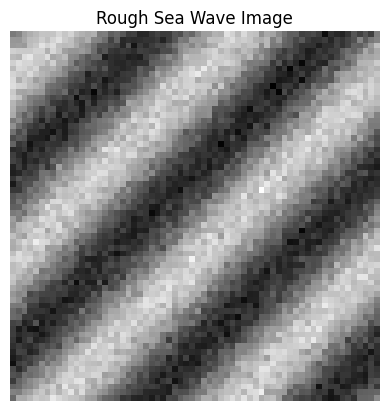

,ax,ay,az,gx,gy,gz
0,-2.278545,2.367169,10.258154,0.028505,-1.720259,0.588577
1,0.610229,0.823663,7.749170,-1.713080,0.019683,-0.573460
2,-1.958075,0.383843,7.846753,1.819737,0.378780,-0.199285
3,2.433107,1.310134,7.966621,-2.487232,0.119171,-1.696070
4,2.016530,2.112765,11.075460,3.266556,1.129629,-2.083950


In [18]:
sample_img = Image.open("dataset/rough/img_000.png")
sample_imu = pd.read_csv("dataset/rough/img_000.csv")

plt.imshow(sample_img)
plt.axis("off")
plt.title("Rough Sea Wave Image")
plt.show()

sample_imu.head()


In [20]:
#dataset/
# ── calm/
# │    ├── img_000.png
# │    ├── img_000.csv
# │    ├── img_001.png
# │    └── ...
# ├── intermediate/
# └── rough/


In [ ]:
# Now a SIMPLER cleaner model that determines sea-state based on generated images


In [21]:
!pip install torch torchvision numpy pillow matplotlib


In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [23]:
IMG_SIZE = 64
SAMPLES_PER_CLASS = 200

SEA_STATES = {
    "calm": 0.2,
    "intermediate": 0.6,
    "rough": 1.2
}


In [24]:
def generate_wave_image(amplitude):
    x = np.linspace(0, 4*np.pi, IMG_SIZE)
    y = np.linspace(0, 4*np.pi, IMG_SIZE)
    X, Y = np.meshgrid(x, y)

    wave = amplitude * np.sin(X + Y)
    noise = np.random.normal(0, 0.3, (IMG_SIZE, IMG_SIZE))
    img = wave + noise

    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)

    return Image.fromarray(img).convert("RGB")


In [25]:
class SeaStateImageDataset(Dataset):
    def __init__(self):
        self.images = []
        self.labels = []

        for label, (state, amp) in enumerate(SEA_STATES.items()):
            for _ in range(SAMPLES_PER_CLASS):
                self.images.append(generate_wave_image(amp))
                self.labels.append(label)

        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.transform(self.images[idx]), self.labels[idx]


In [26]:
class ImageAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*16*16, 32)  # latent space
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 32*16*16),
            nn.ReLU(),
            nn.Unflatten(1, (32,16,16)),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z


In [27]:
class SeaStateClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, z):
        return self.net(z)


In [28]:
#training setup
dataset = SeaStateImageDataset()
loader = DataLoader(dataset, batch_size=32, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

ae = ImageAutoencoder().to(device)
classifier = SeaStateClassifier().to(device)

recon_loss = nn.MSELoss()
cls_loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    list(ae.parameters()) + list(classifier.parameters()),
    lr=1e-3
)


In [36]:
def generate_wave_image(amplitude):
    x = np.linspace(0, 4*np.pi, IMG_SIZE)
    y = np.linspace(0, 4*np.pi, IMG_SIZE)
    X, Y = np.meshgrid(x, y)

    # Base wave pattern
    wave = np.sin(X + Y)
    noise = np.random.normal(0, 0.4, (IMG_SIZE, IMG_SIZE))
    energy = amplitude * wave + noise

    # Normalize energy
    energy = (energy - energy.min()) / (energy.max() - energy.min())

    # Explicit color channels
    red   = np.clip(amplitude * energy, 0, 1)
    green = np.clip((1 - abs(amplitude - 0.6)) * energy, 0, 1)
    blue  = np.clip((1.2 - amplitude) * energy, 0, 1)

    color_img = np.stack([red, green, blue], axis=2)
    color_img = (color_img * 255).astype(np.uint8)

    return Image.fromarray(color_img, mode="RGB")



In [37]:
# joint training loop ( auto-encoder + classification)
for epoch in range(15):
    total_loss = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        recon, z = ae(imgs)
        logits = classifier(z)

        loss = recon_loss(recon, imgs) + cls_loss(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f}")


Epoch 1 | Loss: 0.0120
Epoch 2 | Loss: 0.0119
Epoch 3 | Loss: 0.0116
Epoch 4 | Loss: 0.0119
Epoch 5 | Loss: 0.0116
Epoch 6 | Loss: 0.0115
Epoch 7 | Loss: 0.0119
Epoch 8 | Loss: 0.0114
Epoch 9 | Loss: 0.0115
Epoch 10 | Loss: 0.0120
Epoch 11 | Loss: 0.0213
Epoch 12 | Loss: 0.0360
Epoch 13 | Loss: 0.0309
Epoch 14 | Loss: 0.0339
Epoch 15 | Loss: 0.0305


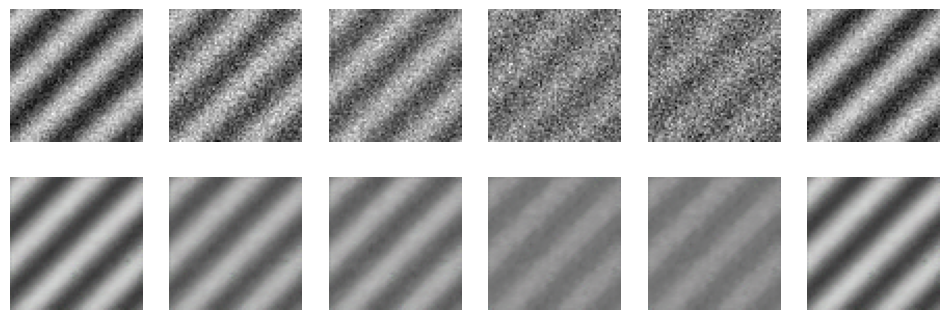

In [38]:
imgs, _ = next(iter(loader))
imgs = imgs.to(device)

with torch.no_grad():
    recon, _ = ae(imgs)

fig, axs = plt.subplots(2, 6, figsize=(12,4))
for i in range(6):
    axs[0,i].imshow(imgs[i].cpu().permute(1,2,0))
    axs[0,i].axis("off")
    axs[1,i].imshow(recon[i].cpu().permute(1,2,0))
    axs[1,i].axis("off")

axs[0,0].set_ylabel("Original")
axs[1,0].set_ylabel("Reconstructed")
plt.show()



/tmp/ipython-input-3699594915.py:22: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(color_img, mode="RGB")


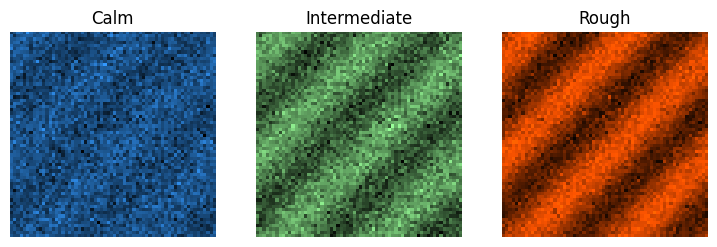

In [39]:
test_imgs = [
    generate_wave_image(0.2),
    generate_wave_image(0.6),
    generate_wave_image(1.2)
]

titles = ["Calm", "Intermediate", "Rough"]

plt.figure(figsize=(9,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(test_imgs[i])
    plt.title(titles[i])
    plt.axis("off")
plt.show()


In [41]:
STATE_NAMES = ["Calm", "Intermediate", "Rough"]

img, label = dataset[0]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    _, z = ae(img)
    pred = classifier(z).argmax(dim=1).item()

print("Predicted:", STATE_NAMES[pred])
print("Actual:", STATE_NAMES[label])


Predicted: Calm
Actual: Calm


In [42]:
SEA_STATE_PARAMS = {
    "calm": {
        "heave": 0.14,    # meters
        "roll": 1.6,      # degrees
        "pitch": 1.8,     # degrees
        "freq": 1.0
    },
    "medium": {
        "heave": 0.42,
        "roll": 3.6,
        "pitch": 4.0,
        "freq": 2.0
    },
    "rough": {
        "heave": 1.75,
        "roll": 4.0,
        "pitch": 6.0,
        "freq": 3.5
    }
}


In [43]:
def generate_wave_image(heave, roll, pitch, freq):
    x = np.linspace(0, 2*np.pi, IMG_SIZE)
    y = np.linspace(0, 2*np.pi, IMG_SIZE)
    X, Y = np.meshgrid(x, y)

    # Convert angles to radians
    roll_rad = np.deg2rad(roll)
    pitch_rad = np.deg2rad(pitch)

    # Directional wave components
    wave_x = np.sin(freq * (X + pitch_rad))
    wave_y = np.sin(freq * (Y + roll_rad))

    # Combined sea surface
    surface = heave * (wave_x + wave_y)

    # Add small-scale surface roughness
    noise = np.random.normal(0, 0.05 * heave, (IMG_SIZE, IMG_SIZE))
    surface += noise

    # Normalize surface height
    surface = (surface - surface.min()) / (surface.max() - surface.min())

    # Ocean-style blue rendering
    blue  = 0.4 + 0.6 * surface
    green = 0.25 + 0.35 * surface
    red   = 0.10 + 0.15 * surface

    ocean_img = np.stack([red, green, blue], axis=2)
    ocean_img = np.clip(ocean_img, 0, 1)

    return Image.fromarray((ocean_img * 255).astype(np.uint8), mode="RGB")


In [44]:
class SeaStateImageDataset(Dataset):
    def __init__(self):
        self.images = []
        self.labels = []

        for label, (state, p) in enumerate(SEA_STATE_PARAMS.items()):
            for _ in range(SAMPLES_PER_CLASS):
                img = generate_wave_image(
                    p["heave"],
                    p["roll"],
                    p["pitch"],
                    p["freq"]
                )
                self.images.append(img)
                self.labels.append(label)

        self.transform = transforms.ToTensor()


/tmp/ipython-input-2894170750.py:32: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray((ocean_img * 255).astype(np.uint8), mode="RGB")


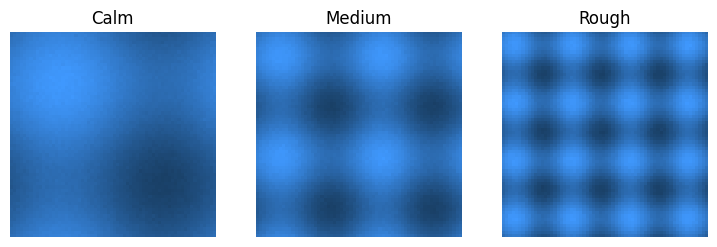

In [45]:
plt.figure(figsize=(9,3))

for i, (state, p) in enumerate(SEA_STATE_PARAMS.items()):
    img = generate_wave_image(
        p["heave"], p["roll"], p["pitch"], p["freq"]
    )
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(state.capitalize())
    plt.axis("off")

plt.show()


Do i need a database for a MPC or an RL? -> MPC (NO) -> RL (Yes).
Optimize MPC based control algorithm.

In [2]:
!pip install casadi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 11.4 MB/s eta 0:00:00


In [1]:
import casadi as ca
import numpy as np

# System parameters
J = 0.05
b = 0.01
Ts = 0.01

A = np.array([[0, 1],
              [0, -b/J]])
B = np.array([[0],
              [1/J]])

Ad = np.eye(2) + A*Ts
Bd = B*Ts

# MPC parameters
N = 20  # horizon
Q = np.diag([100, 10])
R = np.array([[0.1]])

# Variables
x = ca.MX.sym('x', 2)
u = ca.MX.sym('u')

# Setup optimizer
opti = ca.Opti()

X = opti.variable(2, N+1)
U = opti.variable(1, N)

x0 = opti.parameter(2)

cost = 0

for k in range(N):
    cost += ca.mtimes([X[:,k].T, Q, X[:,k]]) \
            + ca.mtimes([U[:,k].T, R, U[:,k]])

    x_next = ca.mtimes(Ad, X[:,k]) + ca.mtimes(Bd, U[:,k])
    opti.subject_to(X[:,k+1] == x_next)

# Constraints
tau_max = 2.0
opti.subject_to(opti.bounded(-tau_max, U, tau_max))

opti.subject_to(X[:,0] == x0)

opti.minimize(cost)
opti.solver('ipopt')


real-time loop:

In [2]:
while True:
    imu_roll = get_roll()
    imu_roll_rate = get_roll_rate()

    opti.set_value(x0, [imu_roll, imu_roll_rate])

    sol = opti.solve()

    torque = sol.value(U[0,0])

    send_to_motor(torque)


NameError: name 'get_roll' is not defined

In [ ]:
# Replace with datafrom IMU
while True:
    imu_roll = get_roll()
    imu_roll_rate = get_roll_rate()


Streaming output truncated to the last 5000 lines.

Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 7
Number of Lagrangian Hessian evaluations             = 6
Total seconds in IPOPT                               = 0.008

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 154.00us ( 22.00us) 151.35us ( 21.62us)         7
       nlp_g  | 222.00us ( 31.71us) 212.01us ( 30.29us)         7
  nlp_grad_f  | 146.00us ( 18.25us) 144.97us ( 18.12us)         8
  nlp_hess_l  | 201.00us ( 33.50us) 201.15us ( 33.52us)         6
   nlp_jac_g  | 199.00us ( 24.88us) 200.71us ( 25.09us)         8
       total  |   8.27ms (  8.27ms)   8.29ms (  8.29ms)      

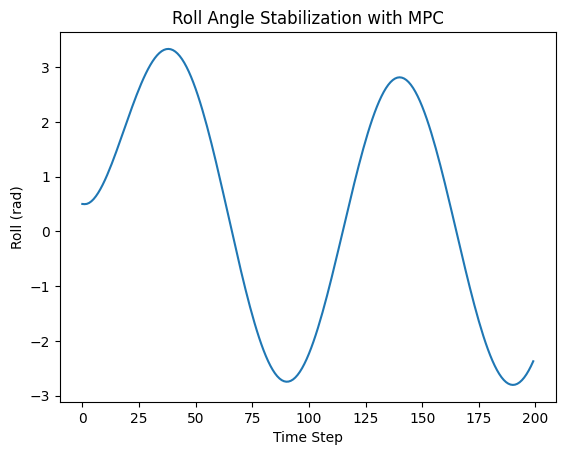

In [3]:
# Working COlAB simulation
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# System parameters
# -----------------------
J = 0.05
b = 0.02
Ts = 0.02

A = np.array([[0, 1],
              [0, -b/J]])
B = np.array([[0],
              [1/J]])

Ad = np.eye(2) + A*Ts
Bd = B*Ts

# -----------------------
# MPC parameters
# -----------------------
N = 15
Q = np.diag([200, 20])
R = np.array([[0.1]])

opti = ca.Opti()

X = opti.variable(2, N+1)
U = opti.variable(1, N)
x0 = opti.parameter(2)

cost = 0

for k in range(N):
    cost += ca.mtimes([X[:,k].T, Q, X[:,k]]) \
          + ca.mtimes([U[:,k].T, R, U[:,k]])

    x_next = ca.mtimes(Ad, X[:,k]) + ca.mtimes(Bd, U[:,k])
    opti.subject_to(X[:,k+1] == x_next)

tau_max = 2.0
opti.subject_to(opti.bounded(-tau_max, U, tau_max))
opti.subject_to(X[:,0] == x0)

opti.minimize(cost)
opti.solver('ipopt')

# -----------------------
# Simulation
# -----------------------
steps = 200
state = np.array([0.5, 0.0])  # initial roll = 0.5 rad

roll_history = []
control_history = []

for t in range(steps):

    # Simulated wave disturbance (rough sea)
    disturbance = 0.2*np.sin(2*np.pi*0.5*t*Ts)

    opti.set_value(x0, state)

    sol = opti.solve()
    u = sol.value(U[0,0])

    # Apply control + disturbance
    state = Ad @ state + Bd.flatten()*u
    state[0] += disturbance

    roll_history.append(state[0])
    control_history.append(u)

# -----------------------
# Plot
# -----------------------
plt.figure()
plt.plot(roll_history)
plt.title("Roll Angle Stabilization with MPC")
plt.xlabel("Time Step")
plt.ylabel("Roll (rad)")
plt.show()


In [4]:
# MPC seems too high level gonna try an LQR approach

LQR Gain K: [[7.43628211 2.56015576]]


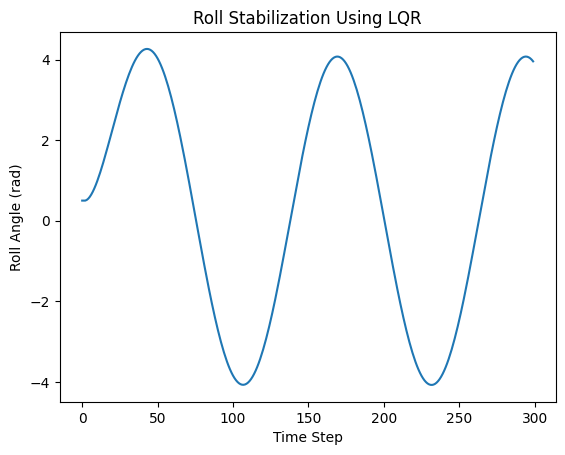

In [5]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

# -------------------------
# Physical Parameters
# -------------------------
J = 0.05      # inertia
b = 0.02      # damping
Ts = 0.02     # sampling time

# -------------------------
# Continuous Model
# -------------------------
A = np.array([[0, 1],
              [0, -b/J]])

B = np.array([[0],
              [1/J]])

# -------------------------
# Discretization
# -------------------------
Ad = np.eye(2) + A*Ts
Bd = B*Ts

# -------------------------
# LQR Weights
# -------------------------
Q = np.diag([200, 20])  # penalize angle heavily
R = np.array([[0.1]])   # penalize torque

# -------------------------
# Solve Discrete Riccati
# -------------------------
P = linalg.solve_discrete_are(Ad, Bd, Q, R)
K = np.linalg.inv(R + Bd.T @ P @ Bd) @ (Bd.T @ P @ Ad)

print("LQR Gain K:", K)

# -------------------------
# Simulation
# -------------------------
steps = 300
state = np.array([0.5, 0.0])  # initial roll disturbance

roll_history = []
control_history = []

for t in range(steps):

    # Simulated sea disturbance (Sea State 5 example)
    disturbance = 0.3*np.sin(2*np.pi*0.4*t*Ts)

    # LQR Control
    u = -K @ state

    # Apply torque limits (motor constraint)
    tau_max = 2.0
    u = np.clip(u, -tau_max, tau_max)

    # Update system
    state = Ad @ state + Bd.flatten()*u
    state[0] += disturbance

    roll_history.append(state[0])
    control_history.append(u[0])

# -------------------------
# Plot
# -------------------------
plt.figure()
plt.plot(roll_history)
plt.title("Roll Stabilization Using LQR")
plt.xlabel("Time Step")
plt.ylabel("Roll Angle (rad)")
plt.show()


In [6]:
# For real-time Jetson: while True:

    phi = get_roll_from_IMU()
    phi_dot = get_roll_rate_from_IMU()

    state = np.array([phi, phi_dot])

    u = -K @ state
    u = np.clip(u, -tau_max, tau_max)

    send_torque_to_motor(u)


IndentationError: unexpected indent (ipython-input-4254038426.py, line 3)

In [ ]:
# Full 2-DOF Python Implementation

LQR Gain K:
 [[ 7.50785388e+00  2.58355964e+00 -3.54364158e-15 -7.98176269e-17]
 [-9.83149377e-15 -2.04086377e-16  8.93375583e+00  3.07452822e+00]]


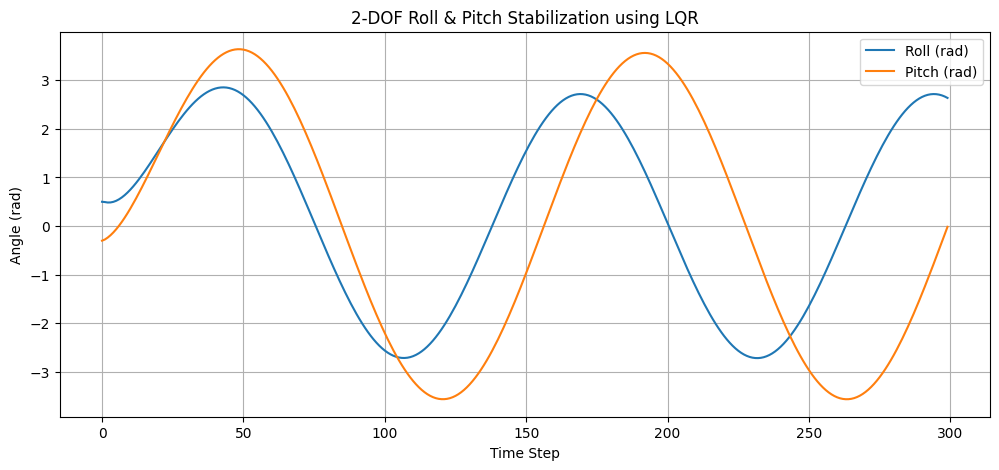

In [7]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

# -------------------------
# Physical parameters
# -------------------------
J_phi = 0.05
b_phi = 0.02

J_theta = 0.06
b_theta = 0.025

Ts = 0.02  # sample time

# -------------------------
# Continuous system matrices
# -------------------------
A = np.array([[0, 1, 0, 0],
              [0, -b_phi/J_phi, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 0, -b_theta/J_theta]])

B = np.array([[0, 0],
              [1/J_phi, 0],
              [0, 0],
              [0, 1/J_theta]])

# -------------------------
# Discretize
# -------------------------
Ad = np.eye(4) + A*Ts
Bd = B*Ts

# -------------------------
# LQR Weights
# -------------------------
Q = np.diag([300, 30, 300, 30])  # penalize angles heavily
R = np.diag([0.1, 0.1])          # penalize torque lightly

# -------------------------
# Solve Discrete Riccati
# -------------------------
P = linalg.solve_discrete_are(Ad, Bd, Q, R)
K = np.linalg.inv(R + Bd.T @ P @ Bd) @ (Bd.T @ P @ Ad)

print("LQR Gain K:\n", K)

# -------------------------
# Simulation
# -------------------------
steps = 300
state = np.array([0.5, 0.0, -0.3, 0.0])  # initial roll/pitch

roll_history = []
pitch_history = []
torque_history = []

tau_max = 2.0

for t in range(steps):

    # Simulated sea disturbance
    disturbance_roll = 0.2*np.sin(2*np.pi*0.4*t*Ts)
    disturbance_pitch = 0.25*np.sin(2*np.pi*0.35*t*Ts)

    # LQR control
    u = -K @ state

    # Torque saturation
    u = np.clip(u, -tau_max, tau_max)

    # Update system
    state = Ad @ state + Bd @ u
    state[0] += disturbance_roll
    state[2] += disturbance_pitch

    roll_history.append(state[0])
    pitch_history.append(state[2])
    torque_history.append(u)

# -------------------------
# Plot results
# -------------------------
plt.figure(figsize=(12,5))
plt.plot(roll_history, label='Roll (rad)')
plt.plot(pitch_history, label='Pitch (rad)')
plt.title("2-DOF Roll & Pitch Stabilization using LQR")
plt.xlabel("Time Step")
plt.ylabel("Angle (rad)")
plt.legend()
plt.grid(True)
plt.show()
